In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib
matplotlib.style.use('seaborn')
%matplotlib inline

In [27]:
train_data_file_path = "../input/train.csv"
test_data_file_path = "../input/test.csv"
df = pd.read_csv(train_data_file_path)

### Exploration

In [5]:
# SibSp: number of siblings and spouses traveling with 
# Parch: number of parents and children traveling with 
# The embarkation : It has three possible values S,C,Q
df['Age'].fillna(df['Age'].median(), inplace=True)
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


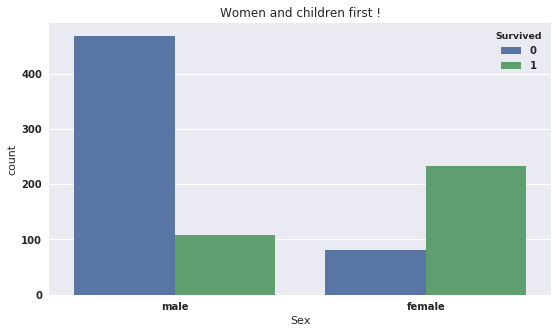

In [22]:
plt.figure(figsize=(9,5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 154}
plt.rc('font', **font)
plt.title("Women and children first !")
sns.countplot(x= 'Sex', hue='Survived', data=df)

Text(0.5, 1.0, 'Women and children first !')

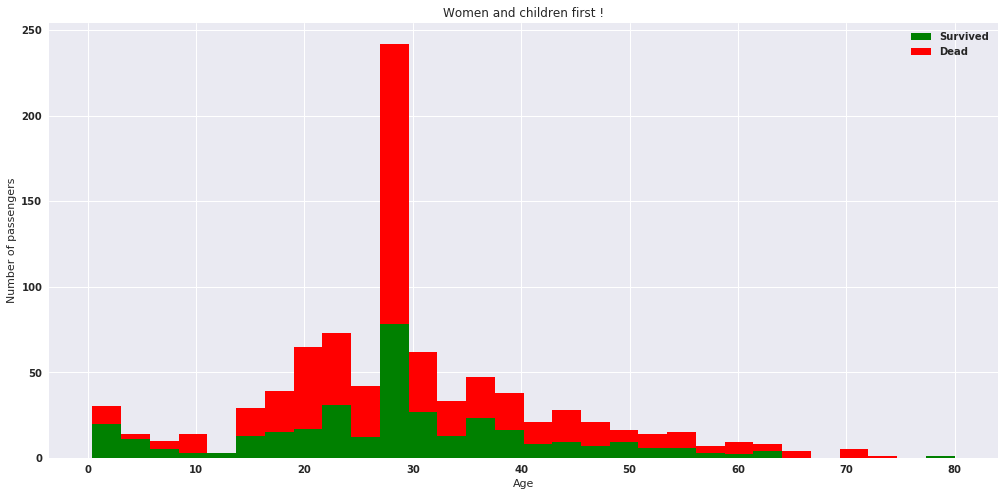

In [20]:
figure = plt.figure(figsize=(17,8))
plt.hist([df[df['Survived']==1]['Age'], 
          df[df['Survived']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30, label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.title("Women and children first !")

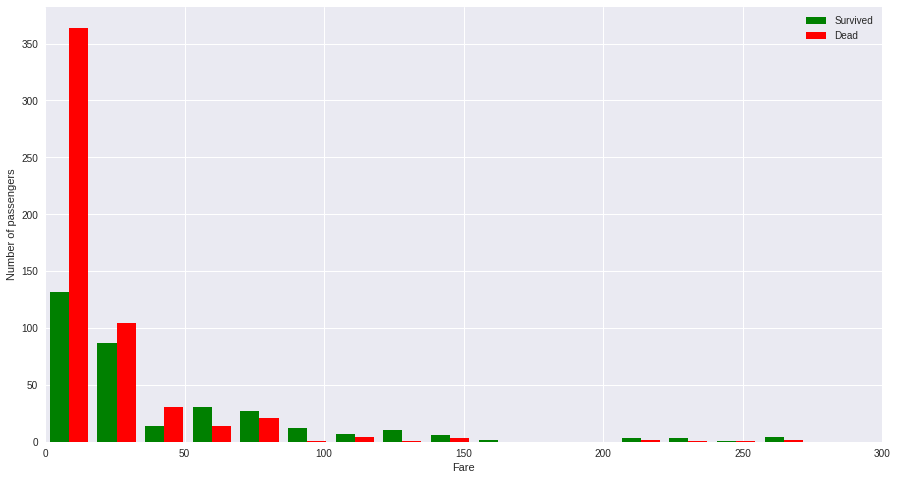

In [8]:
figure = plt.figure(figsize=(15,8))
plt.hist([df[df['Survived']==1]['Fare'],
          df[df['Survived']==0]['Fare']], color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.xlim([0,300])
plt.ylabel('Number of passengers')
plt.legend()

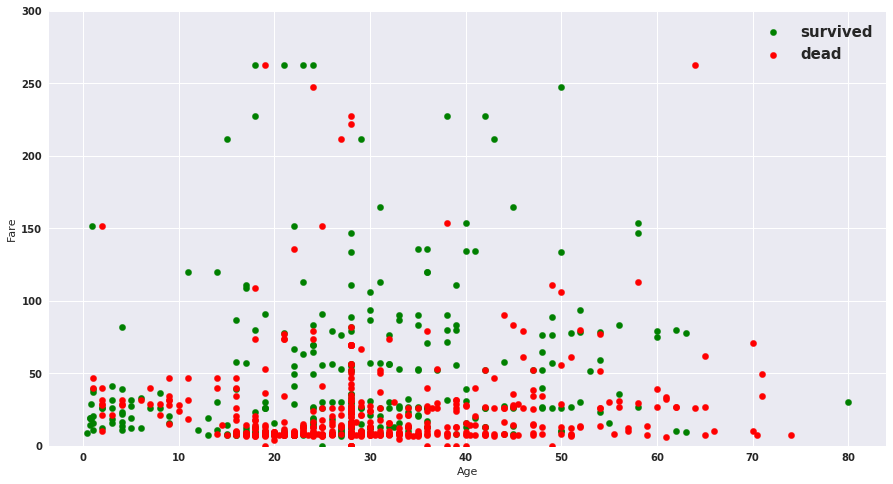

In [23]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(df[df['Survived']==1]['Age'],df[df['Survived']==1]['Fare'], c='green',s=40)
ax.scatter(df[df['Survived']==0]['Age'],df[df['Survived']==0]['Fare'], c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_ylim([0,300])
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

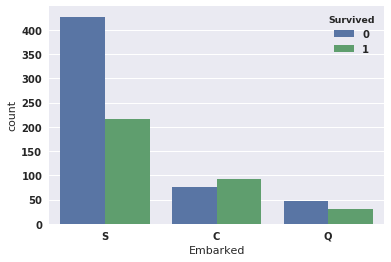

In [24]:
sns.countplot(x= 'Embarked', hue='Survived', data=df)

### Feature Engineering

In [38]:
train = pd.read_csv(train_data_file_path)
test = pd.read_csv(test_data_file_path) 
targets = train.Survived
train.drop('Survived', 1, inplace=True)
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index', inplace=True, axis=1)

In [39]:
# Extracting title from the names
Title_Dictionary = {"Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Lady" :      "Royalty"}
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined['Title'] = combined.Title.apply(lambda x:Title_Dictionary.get(x,x))

In [40]:
grouped_median_train = combined.iloc[:len(train)].groupby(['Sex','Pclass','Title']).median()
grouped_median_test = combined.iloc[len(train):].groupby(['Sex','Pclass','Title']).median()

In [41]:
def fillAges(row, grouped_median):
    if np.isnan(row['Age']):
        return grouped_median.loc[row['Sex'], row['Pclass'], row['Title']]['Age']
    else:
        return row['Age']

In [43]:
# Fills in the missing age in combined based on these different attributes.
combined.iloc[:len(train)]['Age'] = combined.iloc[:len(train)].apply(lambda r : fillAges(r, grouped_median_train), axis=1)
combined.iloc[len(train):]['Age'] = combined.iloc[len(train):].apply(lambda r : fillAges(r, grouped_median_test), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
combined.drop('Name', axis=1, inplace=True)
le_title = LabelEncoder()
combined['Title'] = le_title.fit_transform(combined['Title'])

In [45]:
# Fills the fare by the mean
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

# Fills the embarked by the most common
combined.Embarked.fillna('S', inplace=True)

le_embarked = LabelEncoder()
combined['Embarked'] = le_embarked.fit_transform(combined['Embarked'])

# Replacing missing cabins with U (for Uknown)
combined.Cabin.fillna('U', inplace=True)
# mapping each Cabin value with the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])

le_cabin = LabelEncoder()
combined['Cabin'] = le_cabin.fit_transform(combined['Cabin'])

# Encoder for Sex
le_sex = LabelEncoder()
combined['Sex'] = le_sex.fit_transform(combined['Sex'])

In [46]:
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = list(map(lambda t : t.strip(), ticket))
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [47]:
combined['Ticket'] = combined['Ticket'].apply(cleanTicket)
le_ticket = LabelEncoder()
combined['Ticket'] = le_ticket.fit_transform(combined['Ticket'])

In [48]:
# Variables around family feature
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5<=s else 0)

combined.drop('PassengerId', inplace=True, axis=1)

### Modeling

In [49]:
X_train = combined.head(len(train))
X_test = combined[len(train):]
y_train = df.Survived

In [51]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [52]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [54]:
# feat_imp = dict(zip(X_train.columns[np.argsort(clf.feature_importances_)[::-1]],
#     np.sort(clf.feature_importances_)[::-1]))
# new_cols = [k for k,v in feat_imp.items() if v > 0.02]
# train_reduced = X_train[new_cols]
# test_reduced = X_test[new_cols]

model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
test_reduced = model.transform(X_test)
train_reduced.shape, X_train.shape

((891, 4), (891, 14))

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(y_train, n_folds=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(train_reduced, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    model = RandomForestClassifier(**parameters)
    model.fit(train_reduced, y_train)

In [57]:
compute_score(model, train_reduced, y_train, scoring='accuracy')

0.7968655433903342

In [60]:
output = model.predict(test_reduced).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv(test_data_file_path)
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('../output.csv',index=False)

In [61]:
model.score(train_reduced, y_train)

0.8529741863075196